# Embedding Model Selection

# Setup

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
colours = sns.color_palette("Set2")
from sentence_transformers import SentenceTransformer, util
import warnings
warnings.filterwarnings("ignore")
from model_tester import test_embedding_models

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from utils import get_table_from_supabase

#get keys from env
load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

## Recipient Objectives

Until this point, the database was limited to recipient names and activities. I have chosen to extend this to include recipient objectives to hopefully enrich the data and provide another context to test for the embedding model selection. I have updated the database builders, so that objectives can be imported from the start in future iterations, and also created `2_recipients_table_builder/recipient_objectives_importer.py` so that I do not have to re-build the entire database at this point in the project.

----

# Retrieving Data from Supabase and Building Dataframes

I will connect to Supabase and retrieve the relevant records, in order to isolate the text data that I will use to embed and select the best model. For this purpose, I will use the 12 funder-recipient pairs that I have curated for my evaluation app.

In [ ]:
#get evaluation pairs and extract ids
evaluation_pairs = get_table_from_supabase(url, key, "evaluation_pairs")
funder_ids = evaluation_pairs["funder_registered_num"].unique()
eval_recip_ids = evaluation_pairs["recipient_id"].unique()

#add my ratings to compare later
ratings = {
    1: 0.25,
    2: 0.60,
    3: 0.25,
    4: 0.25,
    5: 0.10,
    6: 0.60,
    7: 0.60,
    8: 0.25,
    9: 0.25,
    10: 0.25,
    11: 0.80,
    12: 0.30
}
evaluation_pairs["my_rating"] = evaluation_pairs["id"].map(ratings)

In [ ]:
#get the 12 funders and recipients
funders = get_table_from_supabase(url, key, "funders")
funders = funders[funders["registered_num"].isin(funder_ids)]

recipients = get_table_from_supabase(url, key, "recipients")
recipients = recipients[recipients["recipient_id"].isin(eval_recip_ids)]

#create dataframes
recipients_df = recipients.copy()
funders_df = funders.copy()

#add embedding columns to funder/recipient dfs
funders_df["embeddings"] = None
recipients_df["embeddings"] = None

#add funder and recipient names to pairs df
evaluation_pairs = evaluation_pairs.merge(
    funders_df[["registered_num", "name"]],
    left_on="funder_registered_num",
    right_on="registered_num",
    how="left"
)
evaluation_pairs = evaluation_pairs.rename(columns={"name": "funder_name"})
evaluation_pairs = evaluation_pairs.drop(columns=["registered_num"])
evaluation_pairs = evaluation_pairs.merge(
    recipients_df[["recipient_id", "recipient_name"]],
    on="recipient_id",
    how="left"
)

In [ ]:
#check dfs
print(f"Recipients: {recipients_df.shape} | Funders: {funders_df.shape} | Evaluation Pairs: {evaluation_pairs.shape}")

In [ ]:
#create checkpoint - save dfs to pickle
# recipients_df.to_pickle("recipients_df.pkl")
# funders_df.to_pickle("funders_df.pkl")
# evaluation_pairs.to_pickle("evaluation_pairs.pkl")

In [2]:
recipients_df = pd.read_pickle("recipients_df.pkl")
funders_df = pd.read_pickle("funders_df.pkl")
evaluation_pairs = pd.read_pickle("evaluation_pairs.pkl")

----

# Embedding Model Evaluation by Sections

I have chosen to test four models on my small evaluation dataset: 
- `all-MiniLM-L6-v2`
- `snowflake-arctic-embed-s`
- `all-roberta-large-v1`
- `bge-large-en-v1.5` 

Snowflake's model is generally finetuned for retrieval but I have decided to include it as it has performed so highly against other benchmarks and compared to major competitors (Merrick et al, 2024). The other models are consistent with the analysis by Pavlyshenko and Stasiuk (2025), who found these architectures to be reliable on semantic similarity tasks.

In [3]:
#add model names
models = ["all-MiniLM-L6-v2", "Snowflake/snowflake-arctic-embed-s", "all-roberta-large-v1", "BAAI/bge-large-en-v1.5"]

## Test 1 - Activities Only

In [4]:
#prepare text columns
recipients_df["recipients_text"] = recipients_df["recipient_activities"].fillna("").str.lower()
funders_df["funders_text"] = funders_df["activities"].fillna("").str.lower()

results_act = []

In [5]:
#test models
results_act_df, pairs_act = test_embedding_models(
    models_list=models,
    funders_df=funders_df,
    recipients_df=recipients_df,
    evaluation_pairs=evaluation_pairs
)

all-MiniLM-L6-v2: 2.8s
Snowflake/snowflake-arctic-embed-s: 4.2s
all-roberta-large-v1: 16.3s
BAAI/bge-large-en-v1.5: 18.1s

Total test time: 41.4s


In [6]:
results_act_df

,model,correlation
0,all-MiniLM-L6-v2,0.428581
1,Snowflake/snowflake-arctic-embed-s,0.494854
2,all-roberta-large-v1,0.362084
3,BAAI/bge-large-en-v1.5,0.544787


In [7]:
#view pairs with scores from each model
pairs_act

,id,funder_registered_num,recipient_id,my_rating,funder_name,recipient_name,all-MiniLM-L6-v2_sim,Snowflake/snowflake-arctic-embed-s_sim,all-roberta-large-v1_sim,BAAI/bge-large-en-v1.5_sim
0,1,298633,1207372,0.25,BACON CHARITABLE TRUST,CATTON GROVE COMMUNITY CENTRE CIO,0.137608,0.665662,0.056390,0.389297
1,2,1153470,1186661,0.60,BEAVERBROOK FOUNDATION,FAITH IN LATER LIFE LTD,0.417965,0.780605,0.545531,0.617812
2,3,219289,206002,0.25,JESSIE SPENCER TRUST,COMBAT STRESS,0.364039,0.712122,0.352171,0.439073
3,4,287947,1205530,0.25,GRUT TRUST,NORTHERN CANCER VOICES,0.212899,0.643029,0.253448,0.500751
4,5,1190334,1146676,0.10,JOHN WHIPPY FOUNDATION,ANIMAL RESCUE CYMRU,0.243448,0.644499,0.300965,0.473758
5,6,261685,1194238,0.60,MRS WATERHOUSE CHARITABLE TRUST,KIDZ KLUB - LEEDS,0.340170,0.649794,0.470843,0.453494
6,7,1030939,1201946,0.60,TESLER FOUNDATION,SEVENTH HEAVEN,0.359645,0.766179,0.609667,0.621728
7,8,1193351,204330,0.25,FRIENDS OF FAWLEY CHURCH,"BERKSHIRE, BUCKINGHAMSHIRE AND OXFORDSHIRE WIL...",0.310445,0.691930,0.271297,0.545181
8,9,1109733,1000414,0.25,3 TS CHARITABLE TRUST,WELDMAR HOSPICECARE,0.316463,0.752316,0.340665,0.532011
9,10,261567,1000340,0.25,DAVID AND RUTH BEHREND FUND,FREEDOM FROM TORTURE,0.085753,0.667525,0.143934,0.472852


## Test 2 - Objectives Only

In [8]:
#prepare text columns
recipients_df["recipients_text"] = recipients_df["recipient_objectives"].fillna("").str.lower()
funders_df["funders_text"] = funders_df["objectives"].fillna("").str.lower()

results_obj = []

In [9]:
#test models
results_obj_df, pairs_obj = test_embedding_models(
    models_list=models,
    funders_df=funders_df,
    recipients_df=recipients_df,
    evaluation_pairs=evaluation_pairs
)

all-MiniLM-L6-v2: 4.2s
Snowflake/snowflake-arctic-embed-s: 16.2s
all-roberta-large-v1: 85.3s
BAAI/bge-large-en-v1.5: 1463.5s

Total test time: 1569.1s


In [10]:
results_obj_df

,model,correlation
0,all-MiniLM-L6-v2,0.390847
1,Snowflake/snowflake-arctic-embed-s,0.155233
2,all-roberta-large-v1,0.040845
3,BAAI/bge-large-en-v1.5,0.413909


In [11]:
pairs_obj

,id,funder_registered_num,recipient_id,my_rating,funder_name,recipient_name,all-MiniLM-L6-v2_sim,Snowflake/snowflake-arctic-embed-s_sim,all-roberta-large-v1_sim,BAAI/bge-large-en-v1.5_sim
0,1,298633,1207372,0.25,BACON CHARITABLE TRUST,CATTON GROVE COMMUNITY CENTRE CIO,0.453526,0.781387,0.513125,0.581706
1,2,1153470,1186661,0.60,BEAVERBROOK FOUNDATION,FAITH IN LATER LIFE LTD,0.449202,0.757412,0.443285,0.600509
2,3,219289,206002,0.25,JESSIE SPENCER TRUST,COMBAT STRESS,0.268072,0.724604,0.457703,0.577598
3,4,287947,1205530,0.25,GRUT TRUST,NORTHERN CANCER VOICES,0.230132,0.738383,0.422057,0.530364
4,5,1190334,1146676,0.10,JOHN WHIPPY FOUNDATION,ANIMAL RESCUE CYMRU,0.428428,0.772618,0.499018,0.630147
5,6,261685,1194238,0.60,MRS WATERHOUSE CHARITABLE TRUST,KIDZ KLUB - LEEDS,0.381480,0.687084,0.404759,0.563782
6,7,1030939,1201946,0.60,TESLER FOUNDATION,SEVENTH HEAVEN,0.407416,0.801899,0.428882,0.564134
7,8,1193351,204330,0.25,FRIENDS OF FAWLEY CHURCH,"BERKSHIRE, BUCKINGHAMSHIRE AND OXFORDSHIRE WIL...",0.269549,0.709543,0.388170,0.570597
8,9,1109733,1000414,0.25,3 TS CHARITABLE TRUST,WELDMAR HOSPICECARE,0.301665,0.789241,0.408023,0.593135
9,10,261567,1000340,0.25,DAVID AND RUTH BEHREND FUND,FREEDOM FROM TORTURE,-0.018109,0.621459,0.118740,0.461444


## Test 3 - Activities and Objectives (API Only)

In [13]:
#reject bge-large-en-v1.5
models = ["all-MiniLM-L6-v2", "Snowflake/snowflake-arctic-embed-s", "all-roberta-large-v1"]

In [14]:
#prepare text columns
recipients_df["recipients_text"] = recipients_df["recipient_activities"].fillna("") + "" + recipients_df["recipient_objectives"].fillna("").str.lower()
funders_df["funders_text"] = funders_df["activities"].fillna("") + "" + funders_df["objectives"].fillna("").str.lower()

results_ao_api = []

In [15]:
#test models
results_ao_api, pairs_ao_api = test_embedding_models(
    models_list=models,
    funders_df=funders_df,
    recipients_df=recipients_df,
    evaluation_pairs=evaluation_pairs
)

all-MiniLM-L6-v2: 4.5s
Snowflake/snowflake-arctic-embed-s: 44.2s
all-roberta-large-v1: 68.4s

Total test time: 117.1s


In [16]:
results_ao_api

,model,correlation
0,all-MiniLM-L6-v2,0.358693
1,Snowflake/snowflake-arctic-embed-s,0.221325
2,all-roberta-large-v1,0.439121


In [17]:
pairs_ao_api

,id,funder_registered_num,recipient_id,my_rating,funder_name,recipient_name,all-MiniLM-L6-v2_sim,Snowflake/snowflake-arctic-embed-s_sim,all-roberta-large-v1_sim
0,1,298633,1207372,0.25,BACON CHARITABLE TRUST,CATTON GROVE COMMUNITY CENTRE CIO,0.329249,0.709352,0.402899
1,2,1153470,1186661,0.60,BEAVERBROOK FOUNDATION,FAITH IN LATER LIFE LTD,0.373479,0.732705,0.668525
2,3,219289,206002,0.25,JESSIE SPENCER TRUST,COMBAT STRESS,0.352096,0.696573,0.307511
3,4,287947,1205530,0.25,GRUT TRUST,NORTHERN CANCER VOICES,0.273982,0.608131,0.332433
4,5,1190334,1146676,0.10,JOHN WHIPPY FOUNDATION,ANIMAL RESCUE CYMRU,0.442093,0.719338,0.499278
5,6,261685,1194238,0.60,MRS WATERHOUSE CHARITABLE TRUST,KIDZ KLUB - LEEDS,0.299915,0.636555,0.446879
6,7,1030939,1201946,0.60,TESLER FOUNDATION,SEVENTH HEAVEN,0.404599,0.737443,0.557278
7,8,1193351,204330,0.25,FRIENDS OF FAWLEY CHURCH,"BERKSHIRE, BUCKINGHAMSHIRE AND OXFORDSHIRE WIL...",0.277628,0.684623,0.381304
8,9,1109733,1000414,0.25,3 TS CHARITABLE TRUST,WELDMAR HOSPICECARE,0.297411,0.756840,0.424237
9,10,261567,1000340,0.25,DAVID AND RUTH BEHREND FUND,FREEDOM FROM TORTURE,0.020152,0.654719,0.196893


## Test 4 - Activities and Objectives (Extracted and API)

In [19]:
#prepare text columns
recipients_df["recipients_text"] = recipients_df["recipient_activities"].fillna("") + "" + recipients_df["recipient_objectives"].fillna("").str.lower()
funders_df["funders_text"] = funders_df["activities"].fillna("") + "" + funders_df["objectives"].fillna("") + "" + funders_df["objectives_activities"].fillna("").str.lower()

results_ao_ext = []

In [20]:
#test models
results_ao_ext, pairs_ao_ext = test_embedding_models(
    models_list=models,
    funders_df=funders_df,
    recipients_df=recipients_df,
    evaluation_pairs=evaluation_pairs
)

all-MiniLM-L6-v2: 4.3s
Snowflake/snowflake-arctic-embed-s: 30.6s
all-roberta-large-v1: 77.3s

Total test time: 112.1s


In [21]:
results_ao_ext

,model,correlation
0,all-MiniLM-L6-v2,0.317654
1,Snowflake/snowflake-arctic-embed-s,0.194293
2,all-roberta-large-v1,0.482080


In [22]:
pairs_ao_ext

,id,funder_registered_num,recipient_id,my_rating,funder_name,recipient_name,all-MiniLM-L6-v2_sim,Snowflake/snowflake-arctic-embed-s_sim,all-roberta-large-v1_sim
0,1,298633,1207372,0.25,BACON CHARITABLE TRUST,CATTON GROVE COMMUNITY CENTRE CIO,0.329249,0.709352,0.399218
1,2,1153470,1186661,0.60,BEAVERBROOK FOUNDATION,FAITH IN LATER LIFE LTD,0.373479,0.732705,0.714230
2,3,219289,206002,0.25,JESSIE SPENCER TRUST,COMBAT STRESS,0.351395,0.667134,0.309124
3,4,287947,1205530,0.25,GRUT TRUST,NORTHERN CANCER VOICES,0.273982,0.608131,0.336527
4,5,1190334,1146676,0.10,JOHN WHIPPY FOUNDATION,ANIMAL RESCUE CYMRU,0.442093,0.719338,0.527307
5,6,261685,1194238,0.60,MRS WATERHOUSE CHARITABLE TRUST,KIDZ KLUB - LEEDS,0.292382,0.631720,0.513736
6,7,1030939,1201946,0.60,TESLER FOUNDATION,SEVENTH HEAVEN,0.431671,0.714170,0.509098
7,8,1193351,204330,0.25,FRIENDS OF FAWLEY CHURCH,"BERKSHIRE, BUCKINGHAMSHIRE AND OXFORDSHIRE WIL...",0.277628,0.684623,0.372341
8,9,1109733,1000414,0.25,3 TS CHARITABLE TRUST,WELDMAR HOSPICECARE,0.297411,0.756840,0.393115
9,10,261567,1000340,0.25,DAVID AND RUTH BEHREND FUND,FREEDOM FROM TORTURE,0.050731,0.651542,0.269401


KeyError: 'all-MiniLM-L6-v2_sim'

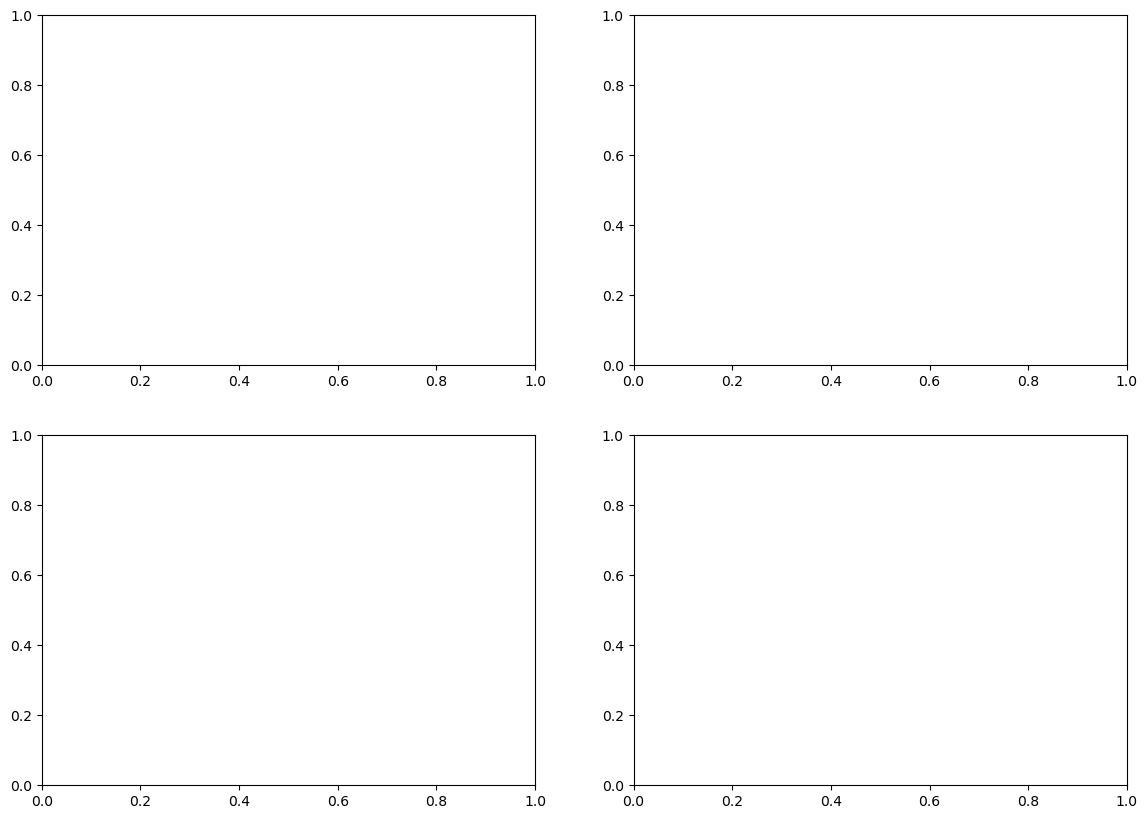

In [23]:
#make scatterplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (model_col, title) in enumerate([
    ("all-MiniLM-L6-v2_sim", "MiniLM"),
    ("Snowflake/snowflake-arctic-embed-s_sim", "Snowflake Arctic Embed"),
    ("all-roberta-large-v1_sim", "Roberta"),
    ("BAAI/bge-large-en-v1.5_sim", "BGE-M3")
]):
    axes[idx].scatter(evaluation_pairs["my_rating"], evaluation_pairs[model_col],
                        alpha=0.6, s=100, color=colours[idx])

    #show line of best fit
    z = np.polyfit(evaluation_pairs["my_rating"], evaluation_pairs[model_col], 1)
    p = np.poly1d(z)
    axes[idx].plot(evaluation_pairs["my_rating"].sort_values(),
                    p(evaluation_pairs["my_rating"].sort_values()),
                    "r-", alpha=0.5, linewidth=2)

    axes[idx].set_xlabel("My Rating")
    axes[idx].set_ylabel("Model Similarity Score")
    axes[idx].set_title(f"{title}\nCorrelation: {results_df.iloc[idx]['correlation']:.3f}")
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()